# A Machine Learning Approach to Visual Perception of Corridor Trails for Mobile Robots

@Author: Artur Leinweber <br>
@E-Mail: arturleinweber@live.de <br>
@University: Westphalian University of Gelsenkirchen <br>

### Imports
tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality.
Importing tf.keras makes TensorFlow easier to use without sacrificing flexibility and performance.

In [1]:
%matplotlib inline  
import tensorflow as tf
from tensorflow.keras import layers, regularizers, utils, preprocessing, optimizers, backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.misc
from imutils import paths
import numpy as np
import time
import math
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

print("Tensorflow Version: " + tf.VERSION)
print("Keras Version: " + tf.keras.__version__)
tf.logging.set_verbosity(tf.logging.ERROR)

Tensorflow Version: 1.13.1
Keras Version: 2.2.4-tf


### Load dataset for testing

In [2]:
DATASET_PATH = os.getcwd() + "/test_dataset/corridor_05"

Genrate a list of image pathes for our testing

In [3]:
imagePaths = list(paths.list_images(DATASET_PATH))
imagePaths = sorted(imagePaths)
print("Size of the dataset: " + str(len(imagePaths)))

Size of the dataset: 309


Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

In [4]:
images_lst = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (101, 101))
    images_lst.append(image)
    
print(imagePaths)

['/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corridor_05/img_00001.jpg', '/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corridor_05/img_00002.jpg', '/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corridor_05/img_00003.jpg', '/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corridor_05/img_00004.jpg', '/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corridor_05/img_00005.jpg', '/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corridor_05/img_00006.jpg', '/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corridor_05/img_00007.jpg', '/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corridor_05/img_00008.jpg', '/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corridor_05/img_00009.jpg', '/home/asy-user/software_projekt/UAV-II/JupyterNotebooks/CNN/test_dataset/corrido

Convert the data into a NumPy array, then preprocess it by scaling all pixel intensities to the range (0, 1)

In [5]:
images_np = np.array(images_lst, dtype="float") / 255.0

### Restore model parameters
Recreate the exact same model, including weights and optimizer.

In [6]:
model = tf.keras.models.load_model('./checkpoints/corridor_weights00000092.h5')

### Inference

Returns whether TensorFlow can access a Nvidia GPU with CUDA

In [7]:
tf.test.is_gpu_available(cuda_only = True)

True

Generates output predictions for the input samples.
Computation is done in batches.

In [8]:
predictions = list()

for i in range(len(images_np)):
    prediction = model.predict(np.expand_dims(images_np[i],axis=0),
                                   batch_size = None,
                                   verbose = 1,
                                   steps = None,
                                   max_queue_size = 10,
                                   workers = 1,
                                   use_multiprocessing = False)
    predictions.append(prediction)
    
predictions = np.asarray(predictions)

1/1 [==============================] - 0s 2ms/sample


1/1 [==============================] - 0s 2ms/sample


Calculate yaw angle for the robot controller

In [9]:
yaw_angles = list()
for i in range(len(predictions)):
    left_propability = predictions[i][0][1]
    right_propability = predictions[i][0][2]

    propability = left_propability - right_propability
    yaw_angle = propability * 30
    yaw_angles.append(yaw_angle)

### Visualizing Results
Generate for each image an activation- and heatmap

In [10]:
heat_maps = []
activation_maps = []

for i in range(len(predictions)):

    FIRST_ELEMENT = i
    prediction_vector_index = np.argmax(predictions[FIRST_ELEMENT])

    # This is the entry in the prediction vector
    model_output = model.output[:, prediction_vector_index]

    # The is the output feature map of the `conv2d_3` layer,
    # the last convolutional layer in CNN
    last_conv_layer = model.get_layer('conv2d_3')

    # This is the gradient of the activated class with regard to
    # the output feature map of `conv2d_3`
    grads = backend.gradients(model_output, last_conv_layer.output)[0]

    # This is a vector of shape (32,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = backend.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `conv2d_3`,
    # given a sample image
    iterate = backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of the corridor
    x = np.expand_dims(images_np[0], axis=0)
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard one of to the left,right or forward class
    for i in range(32):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    activation_maps.append(heatmap)

    # We use cv2 to load the original image
    img = images_np[FIRST_ELEMENT]

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to a numpy array
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # BGR to RGB
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = scipy.misc.toimage(heatmap * 0.4 + img)
    
    heat_maps.append(superimposed_img)

Plot the results

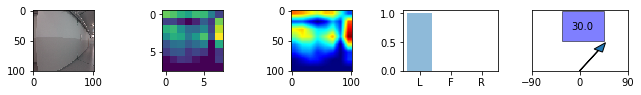

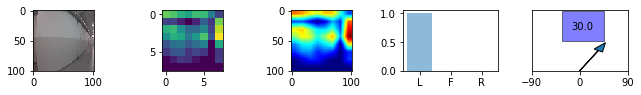

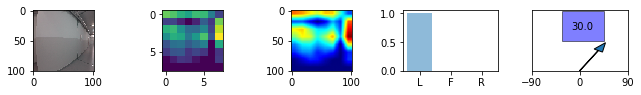

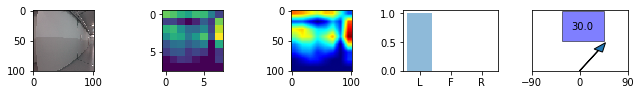

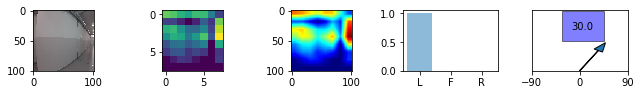

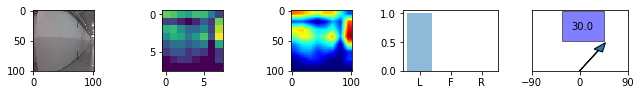

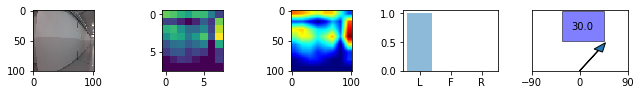

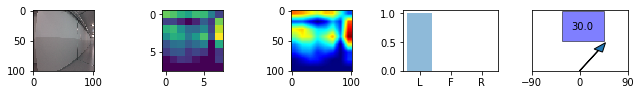

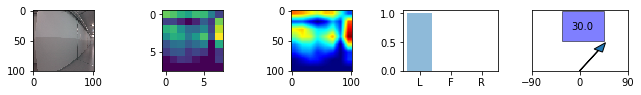

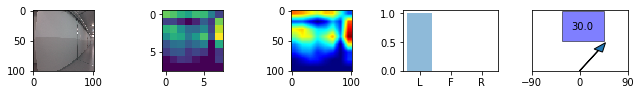

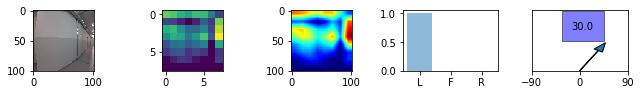

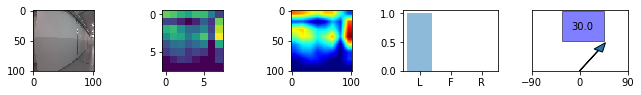

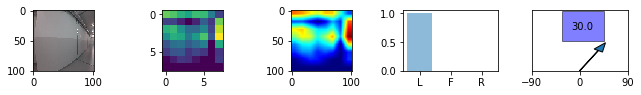

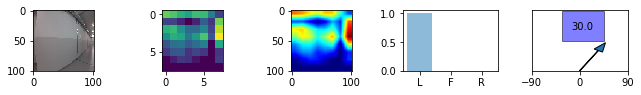

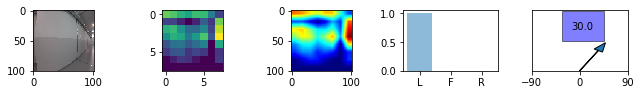

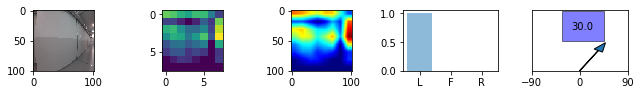

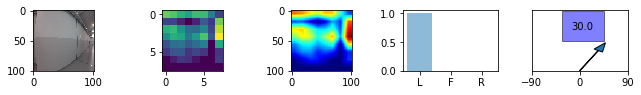

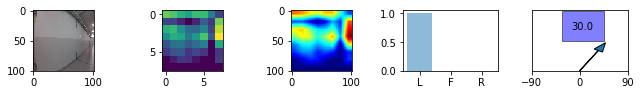

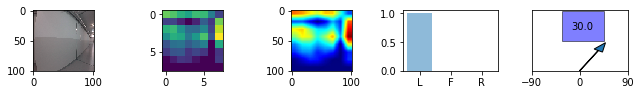

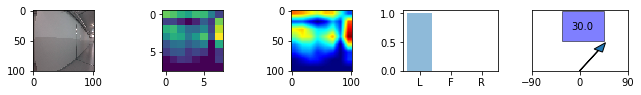

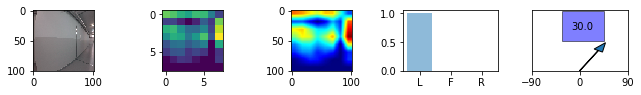

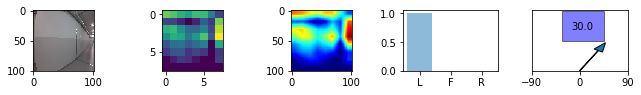

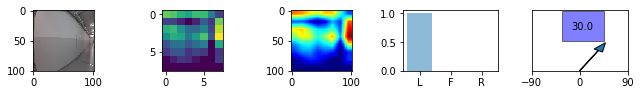

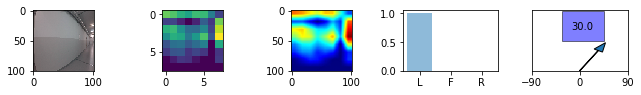

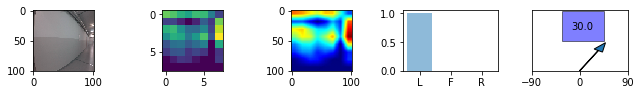

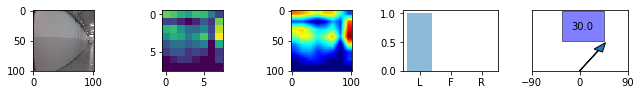

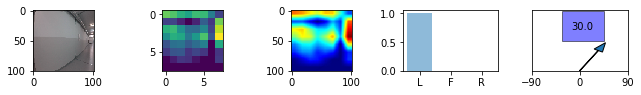

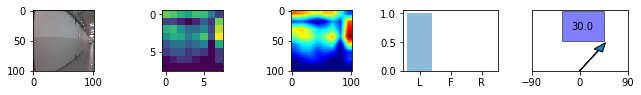

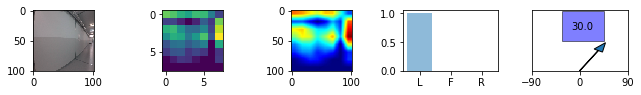

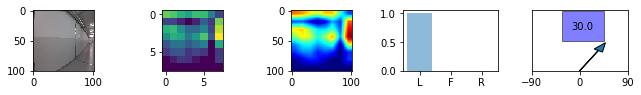

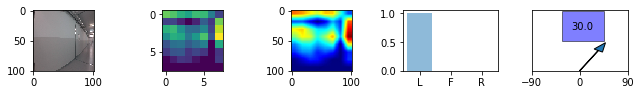

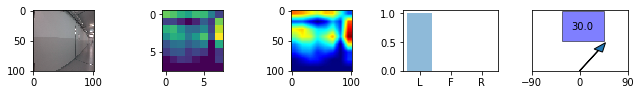

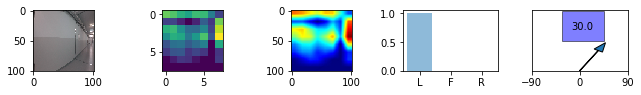

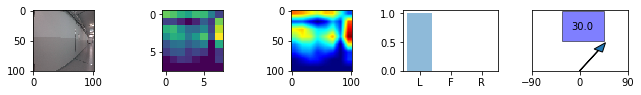

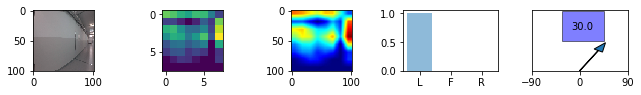

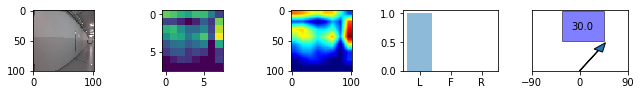

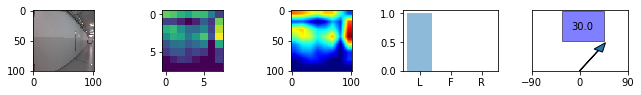

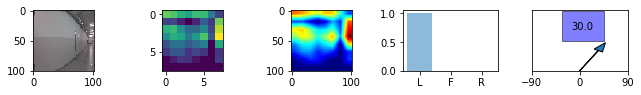

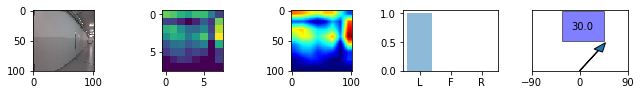

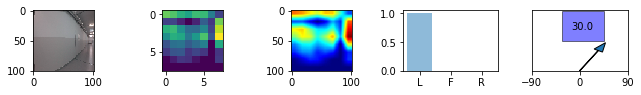

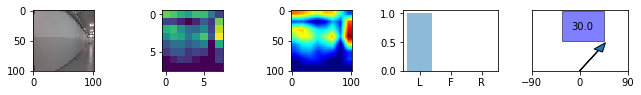

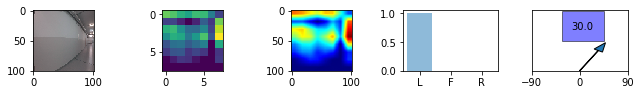

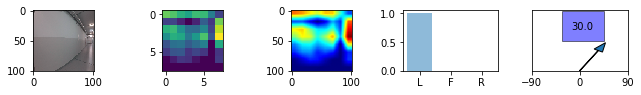

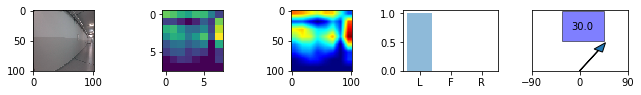

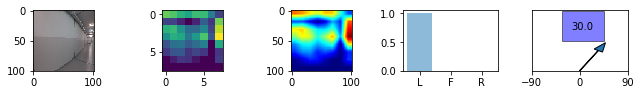

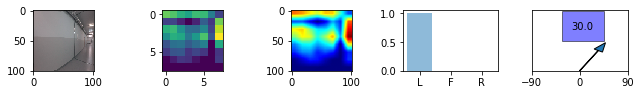

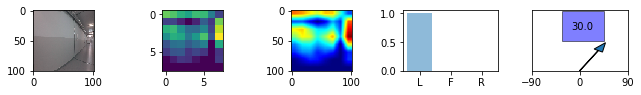

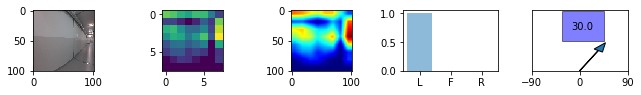

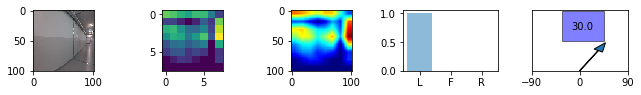

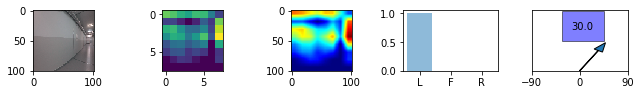

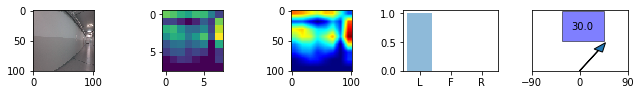

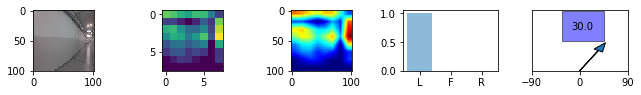

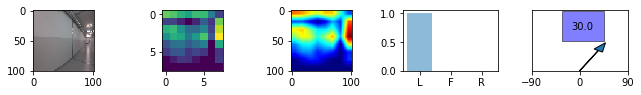

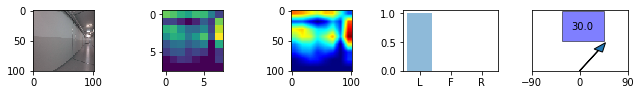

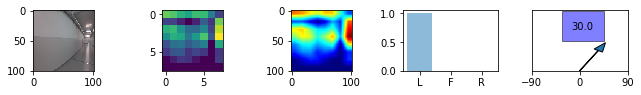

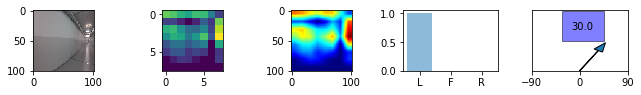

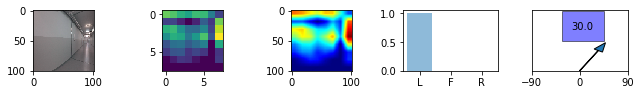

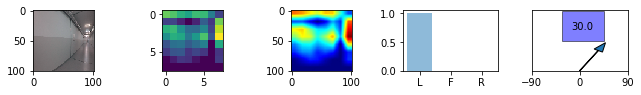

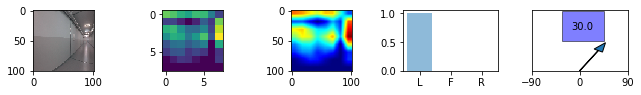

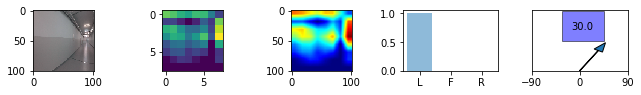

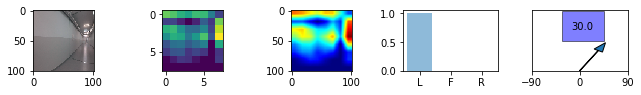

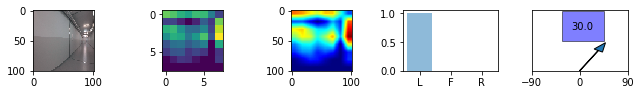

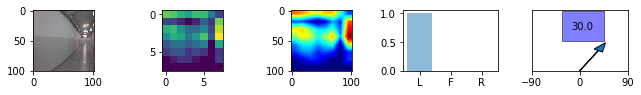

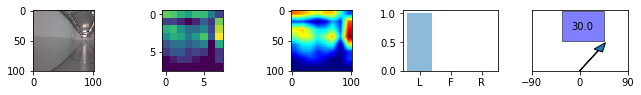

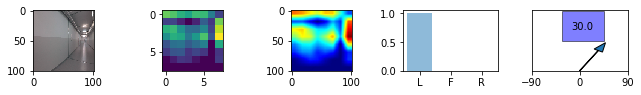

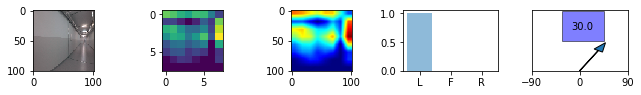

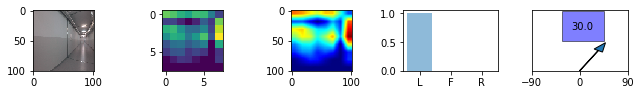

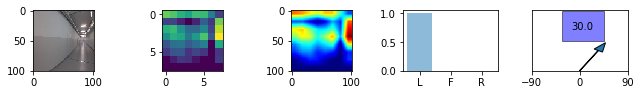

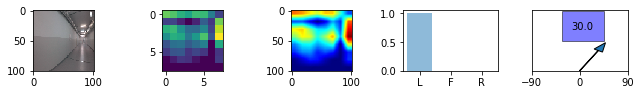

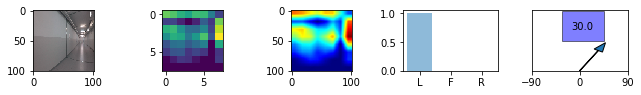

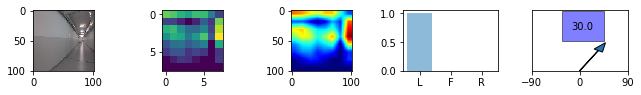

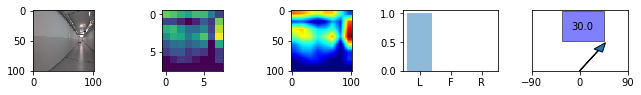

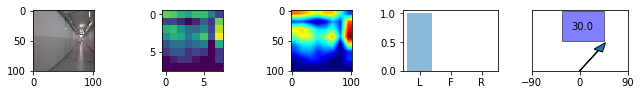

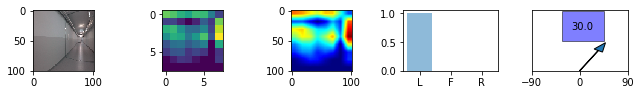

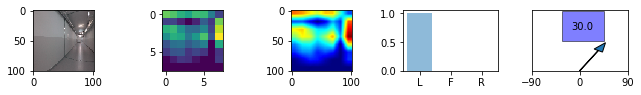

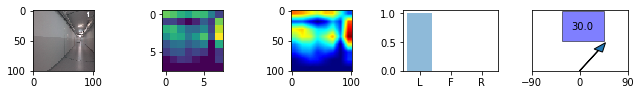

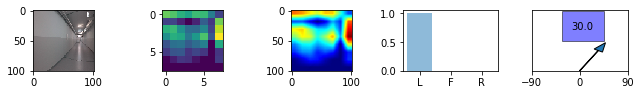

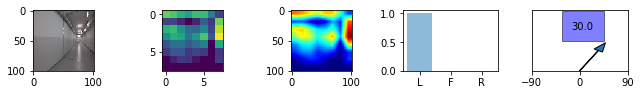

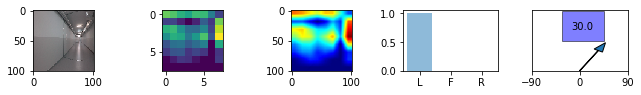

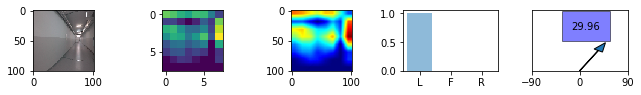

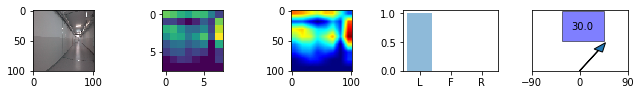

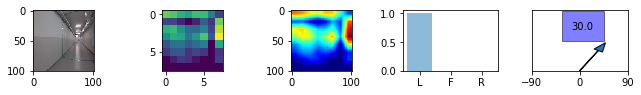

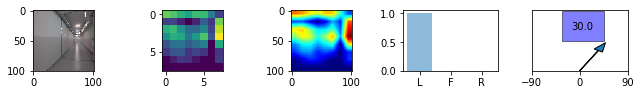

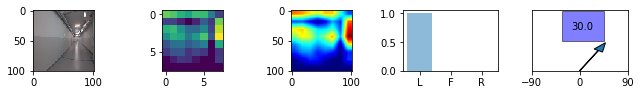

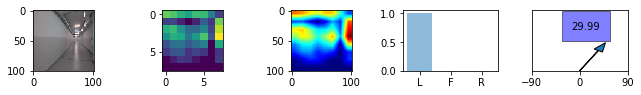

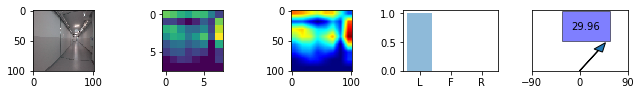

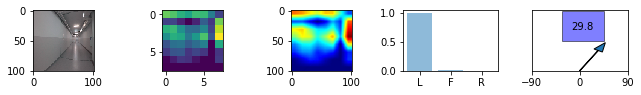

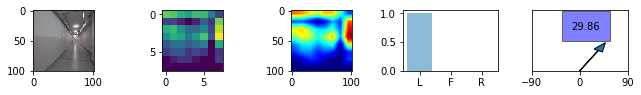

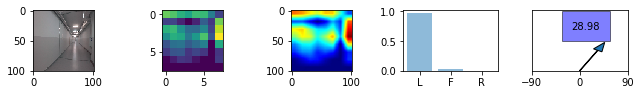

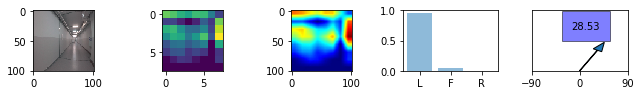

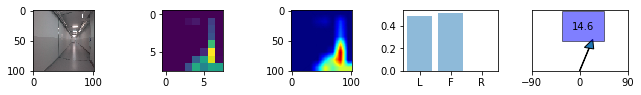

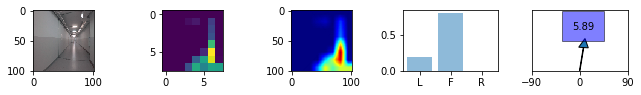

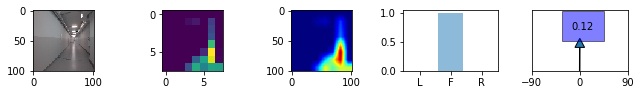

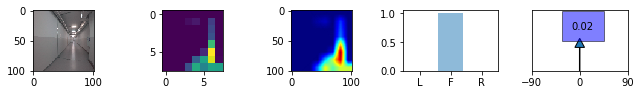

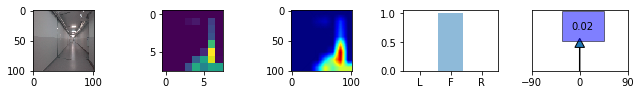

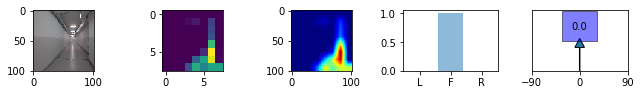

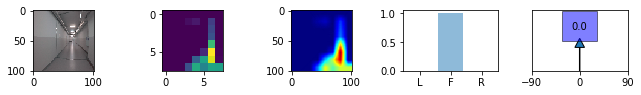

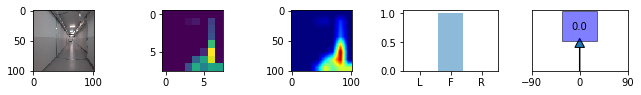

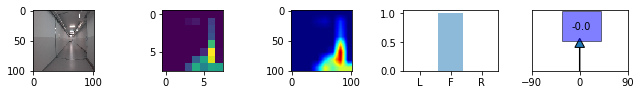

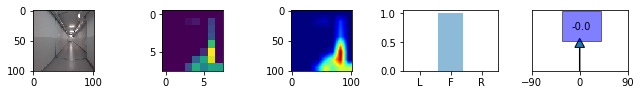

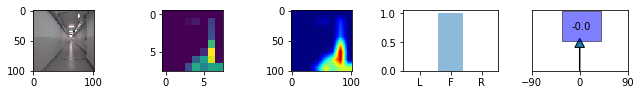

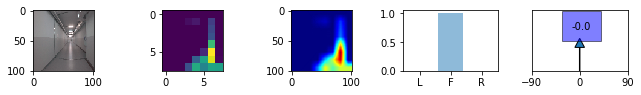

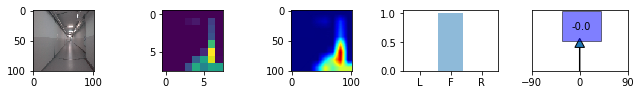

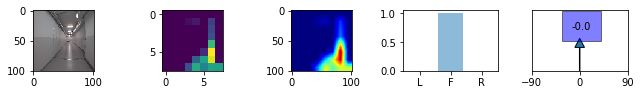

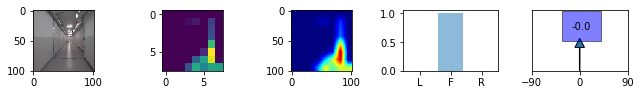

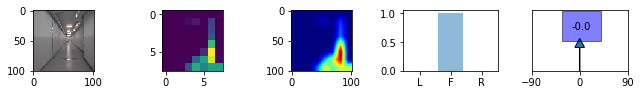

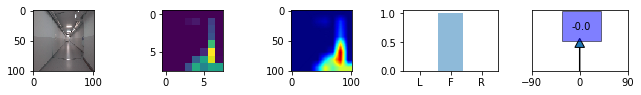

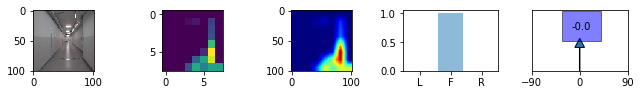

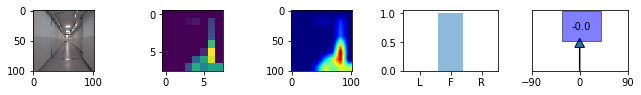

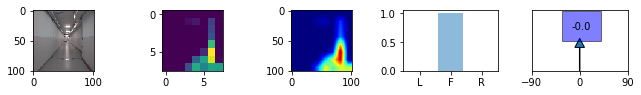

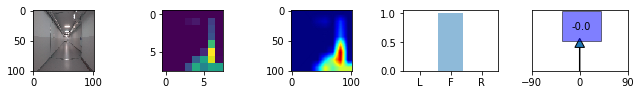

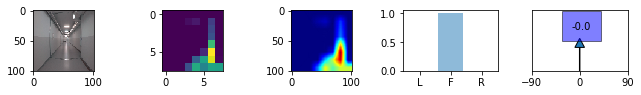

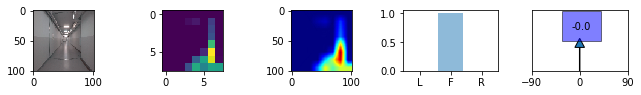

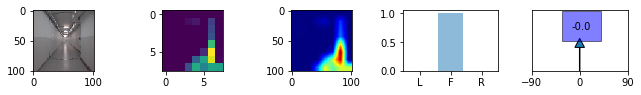

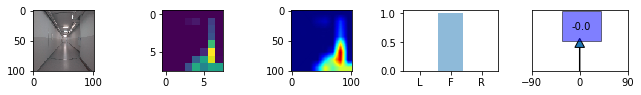

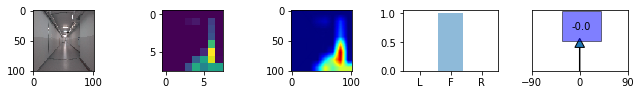

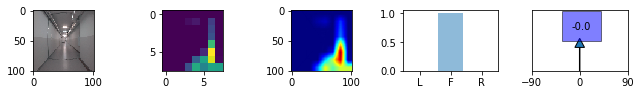

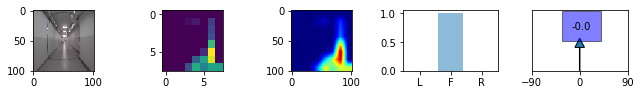

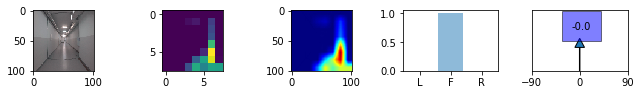

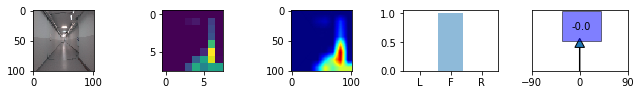

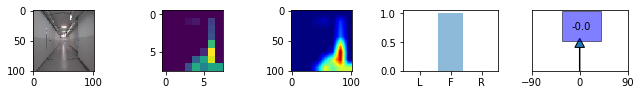

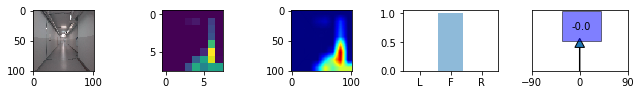

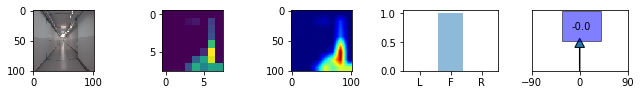

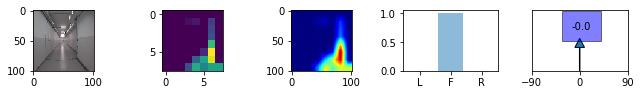

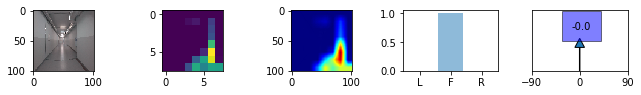

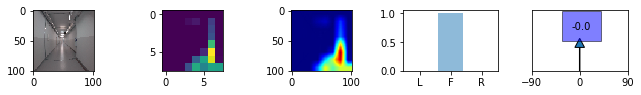

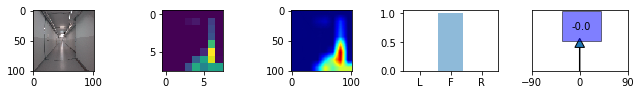

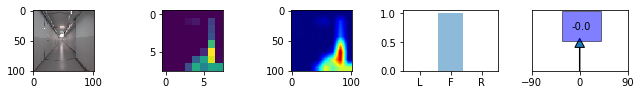

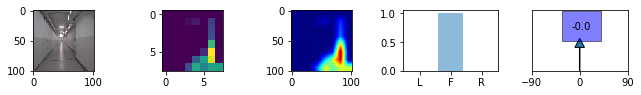

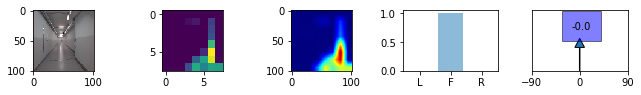

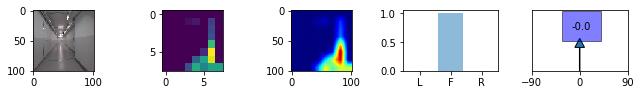

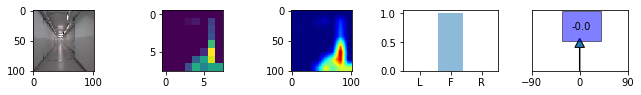

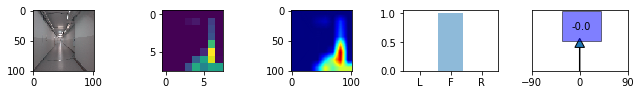

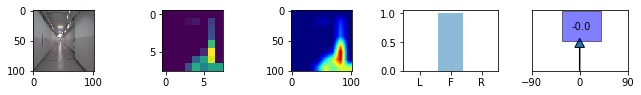

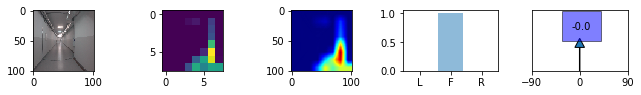

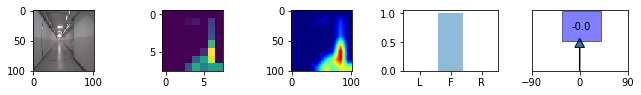

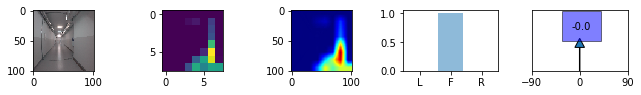

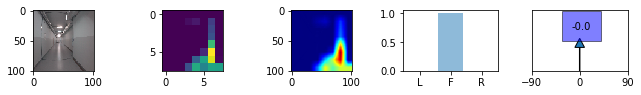

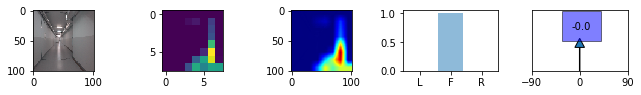

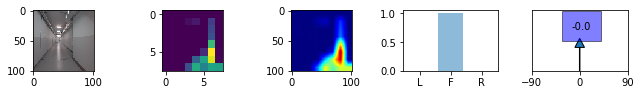

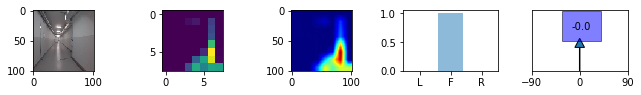

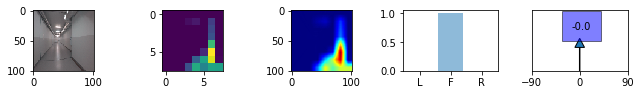

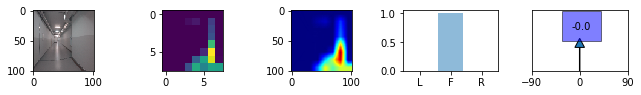

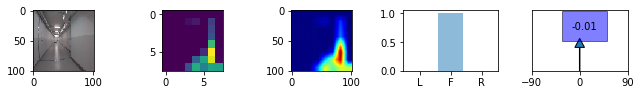

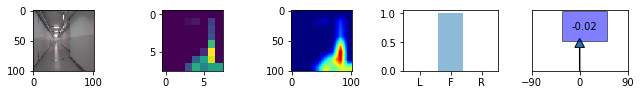

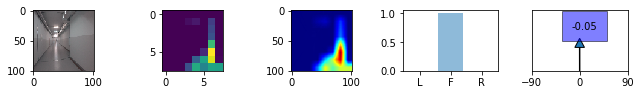

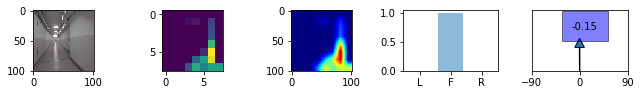

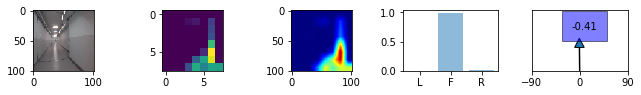

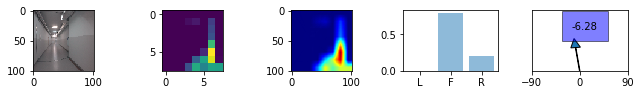

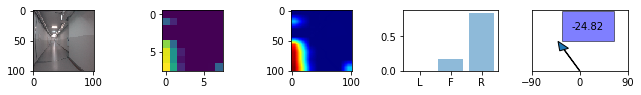

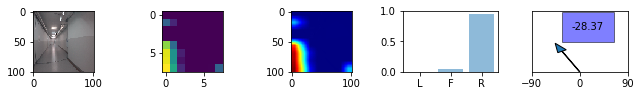

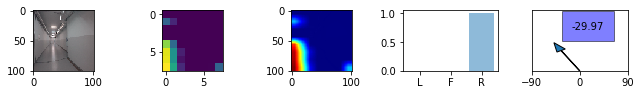

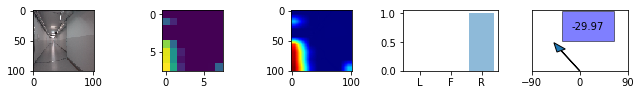

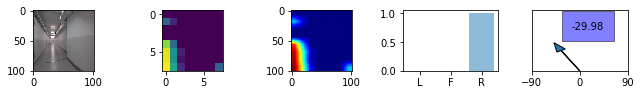

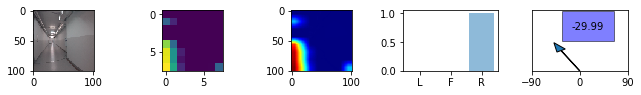

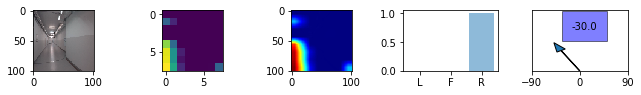

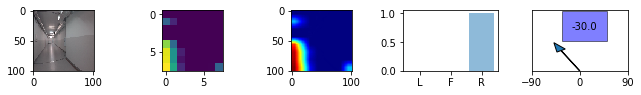

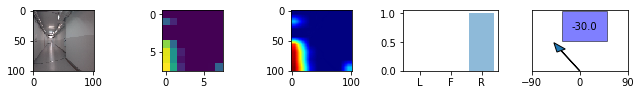

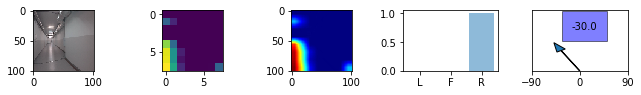

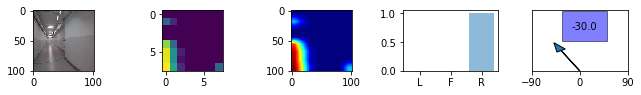

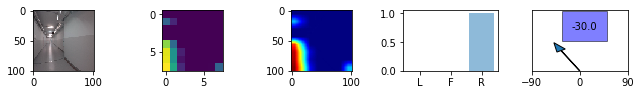

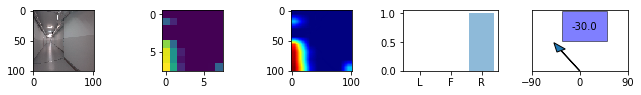

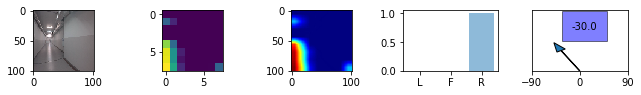

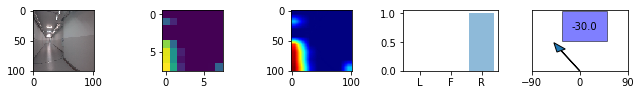

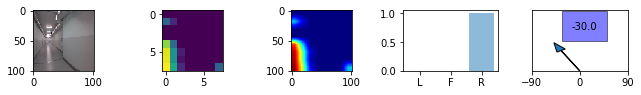

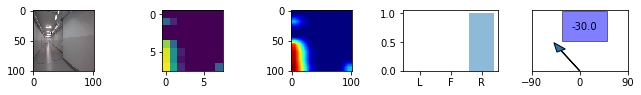

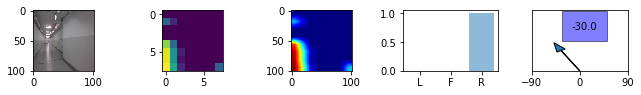

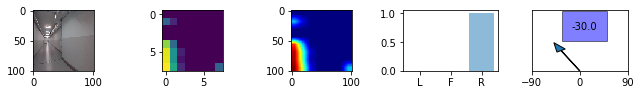

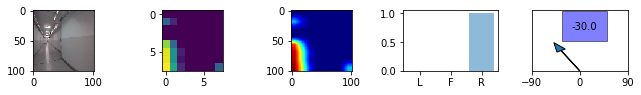

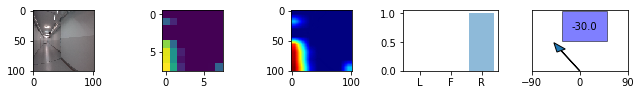

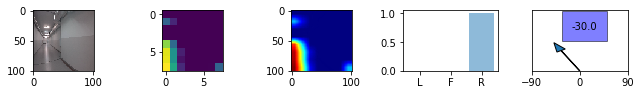

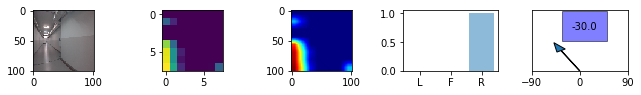

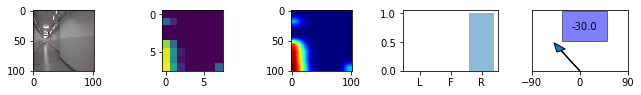

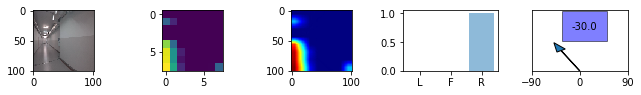

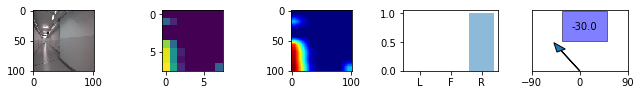

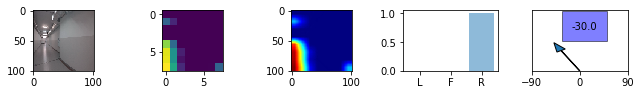

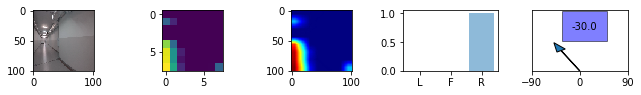

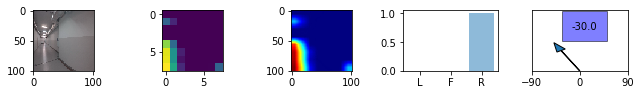

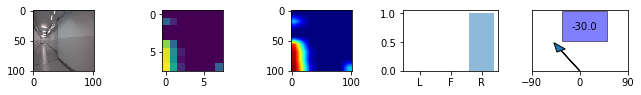

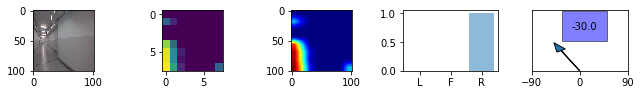

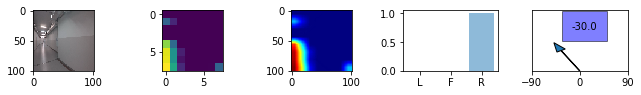

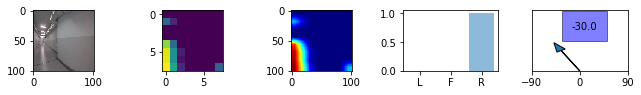

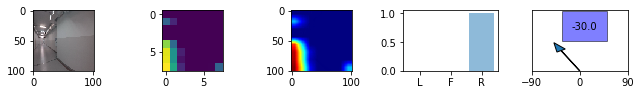

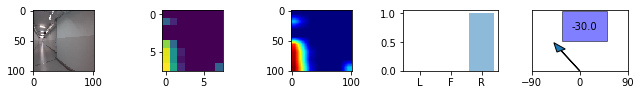

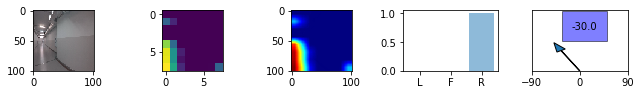

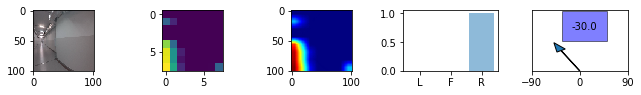

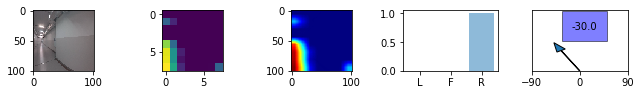

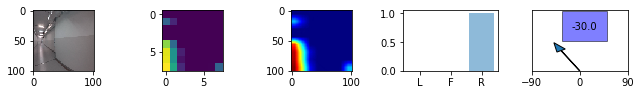

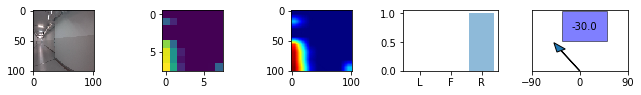

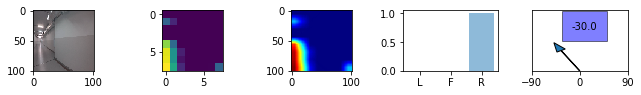

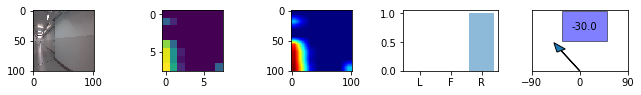

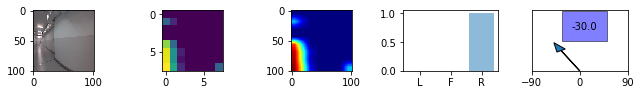

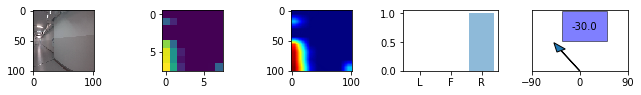

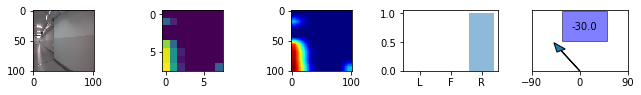

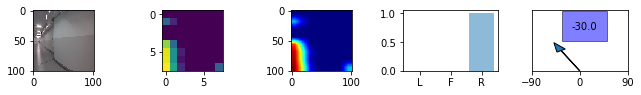

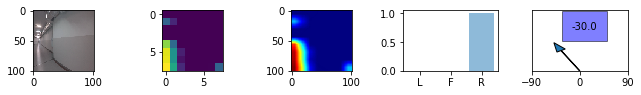

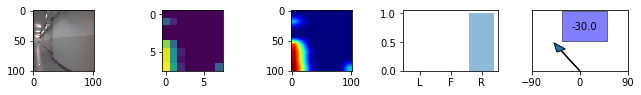

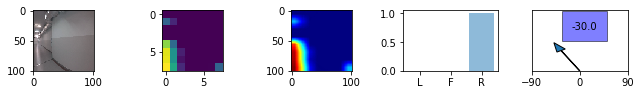

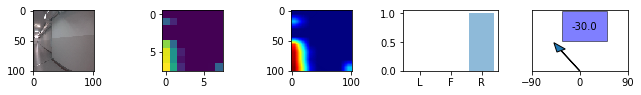

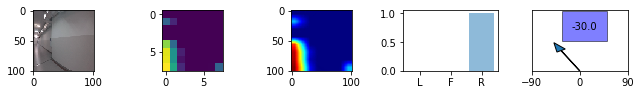

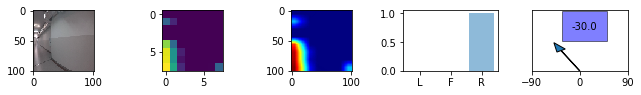

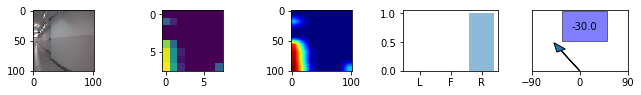

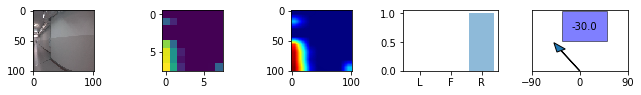

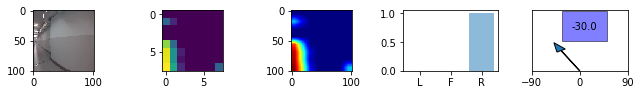

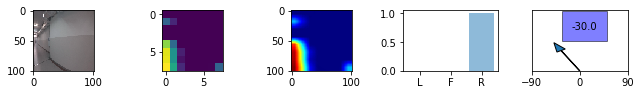

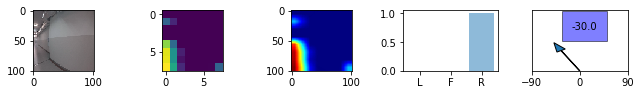

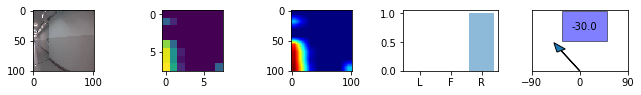

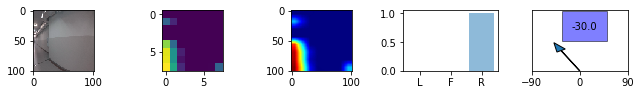

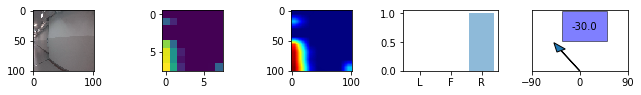

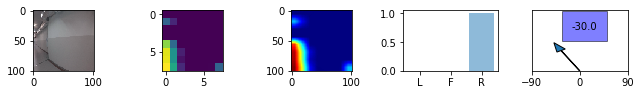

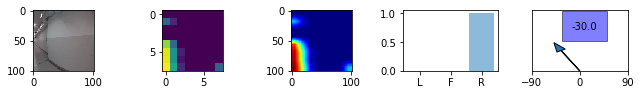

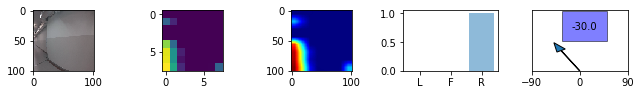

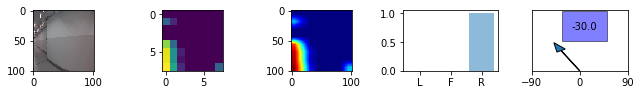

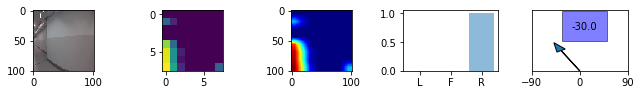

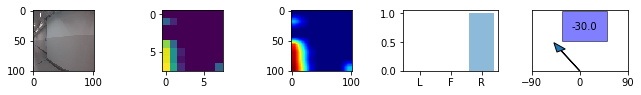

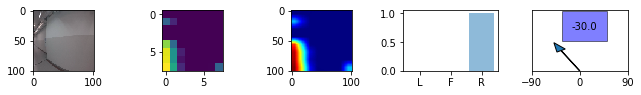

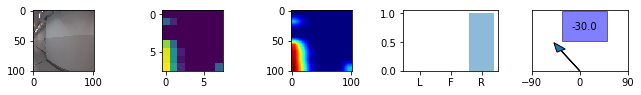

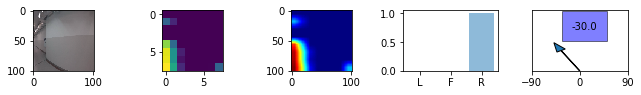

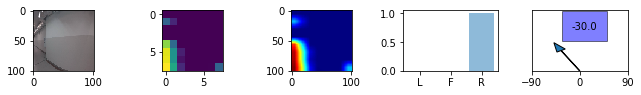

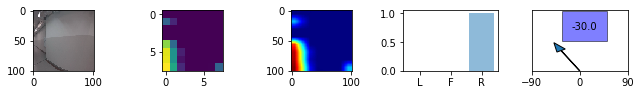

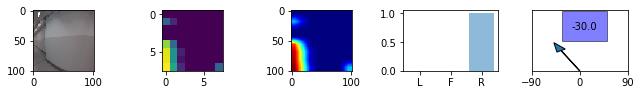

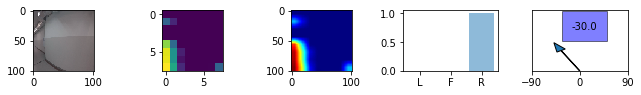

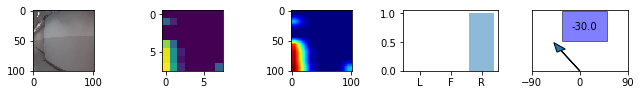

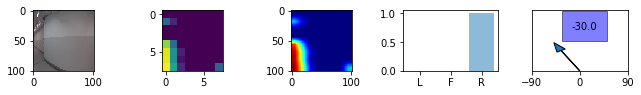

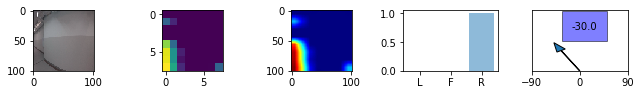

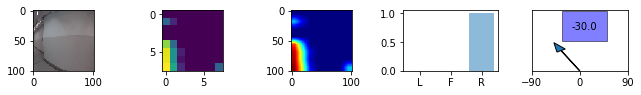

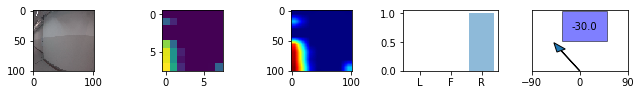

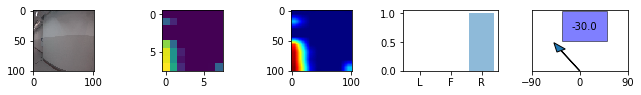

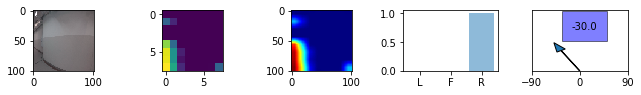

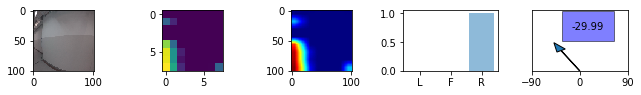

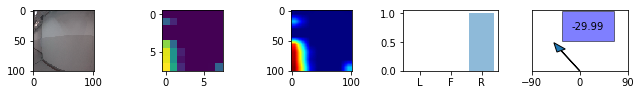

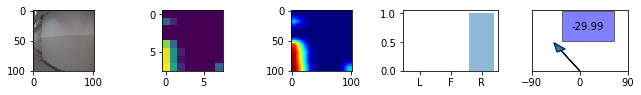

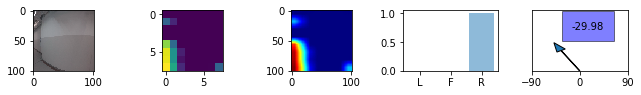

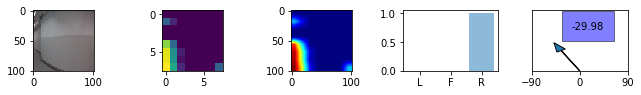

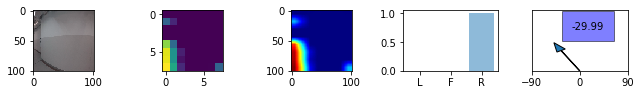

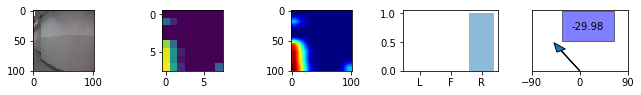

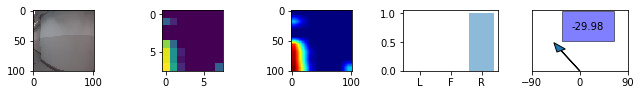

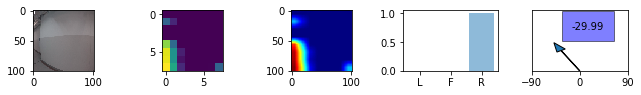

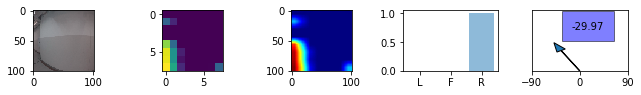

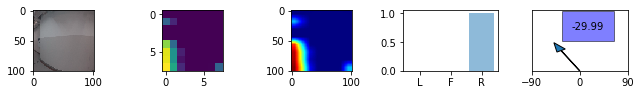

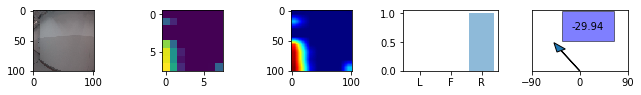

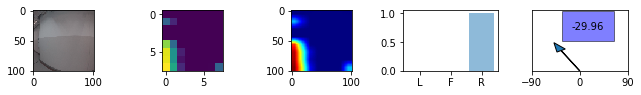

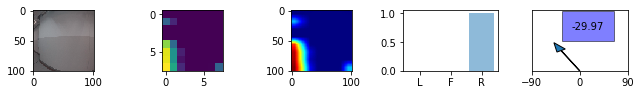

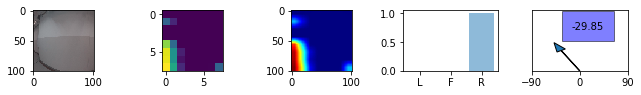

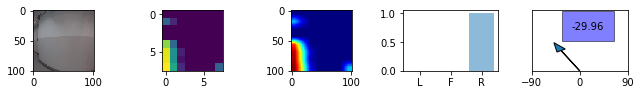

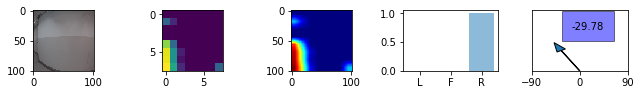

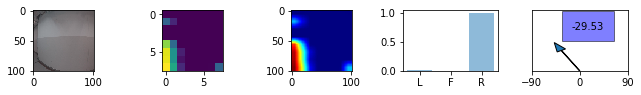

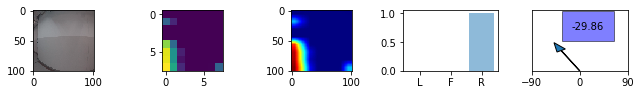

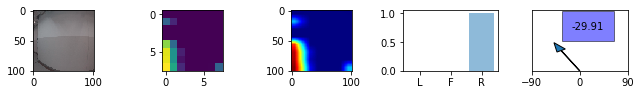

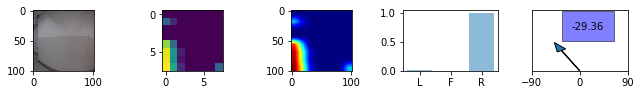

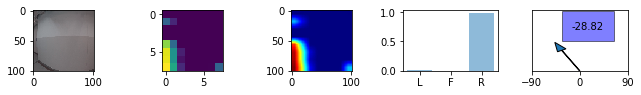

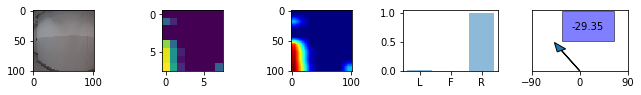

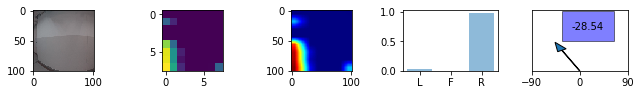

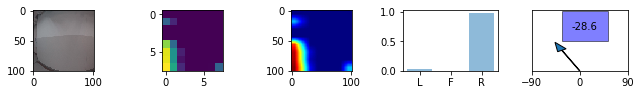

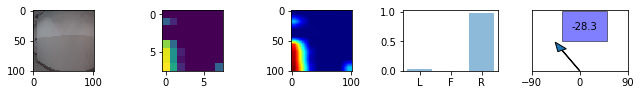

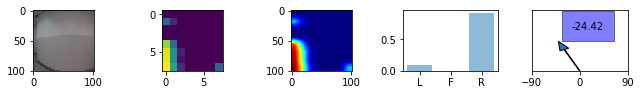

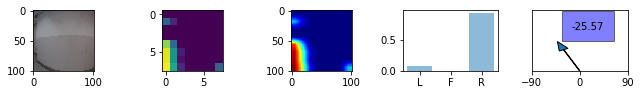

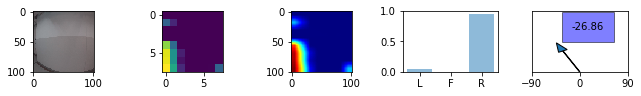

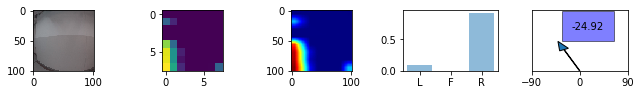

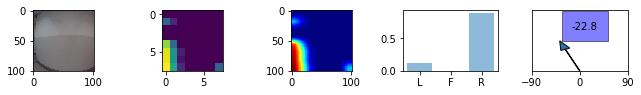

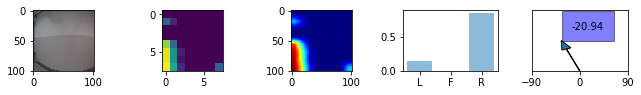

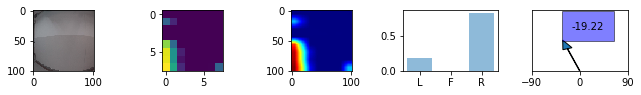

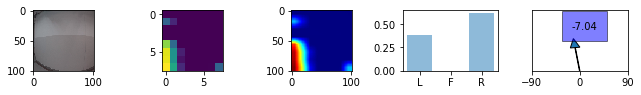

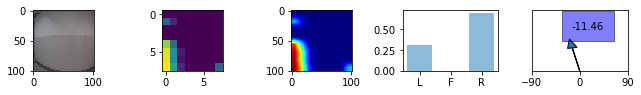

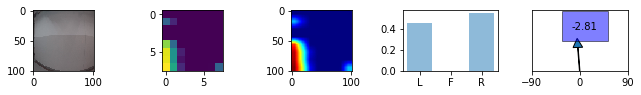

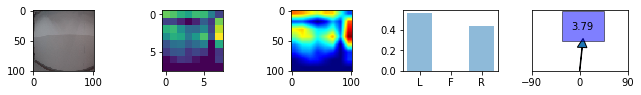

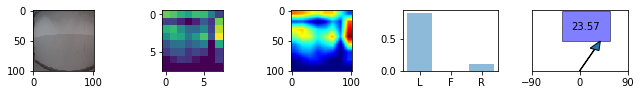

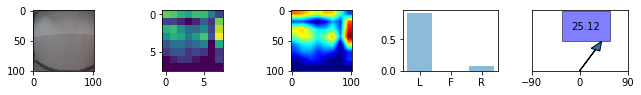

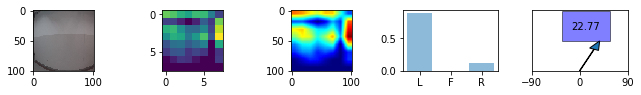

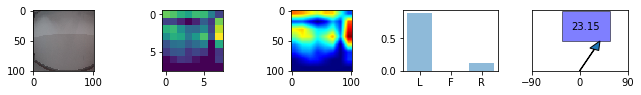

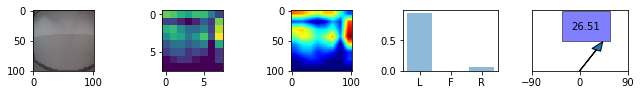

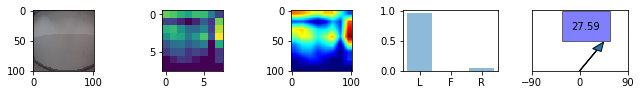

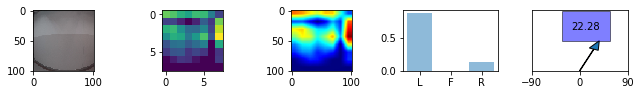

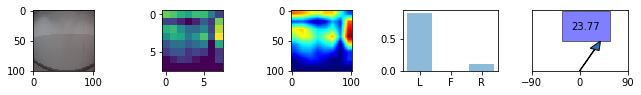

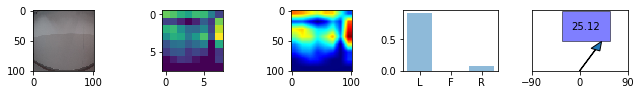

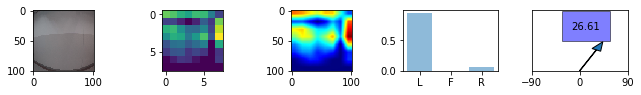

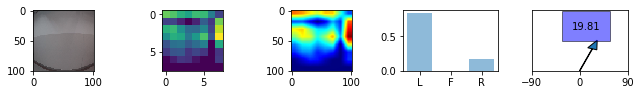

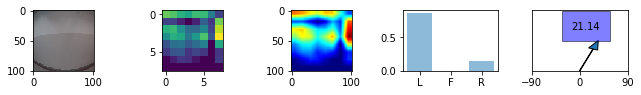

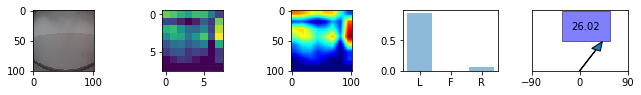

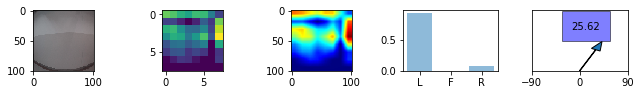

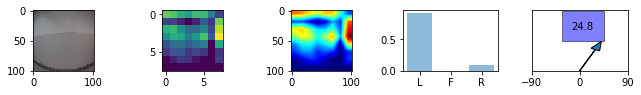

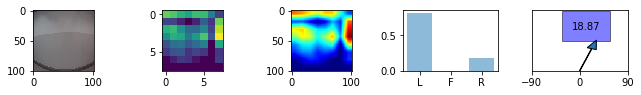

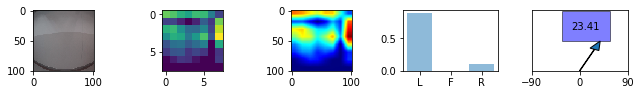

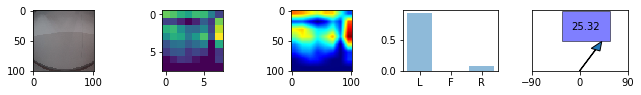

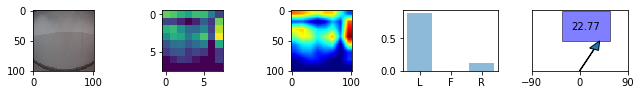

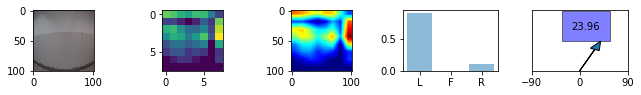

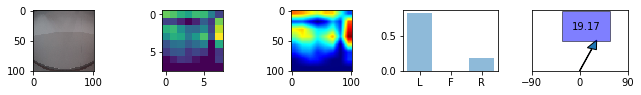

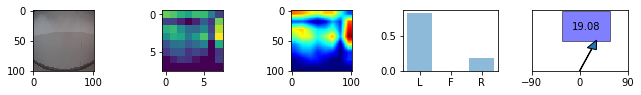

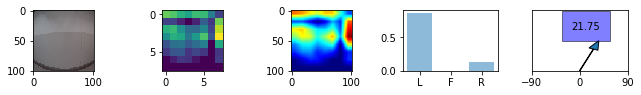

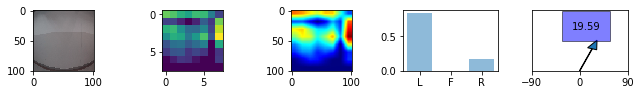

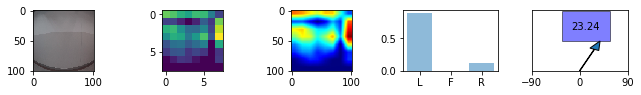

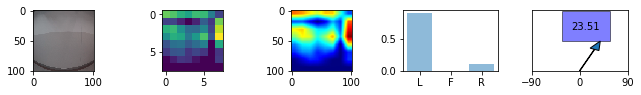

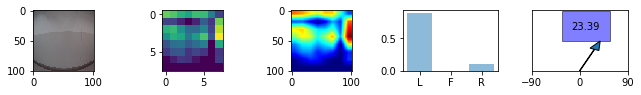

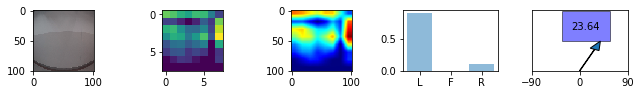

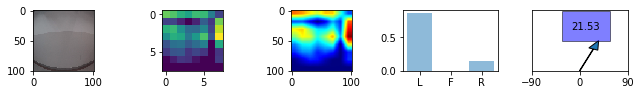

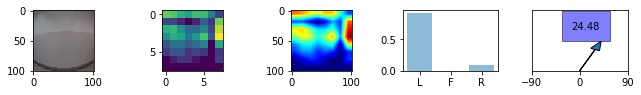

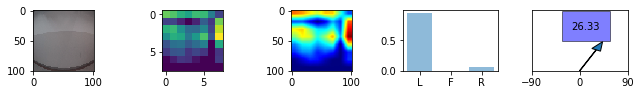

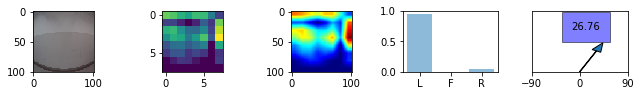

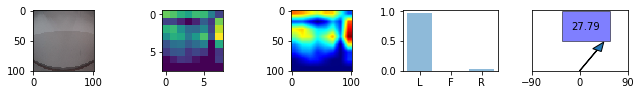

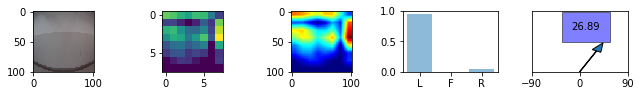

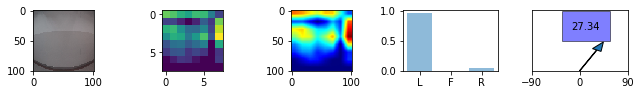

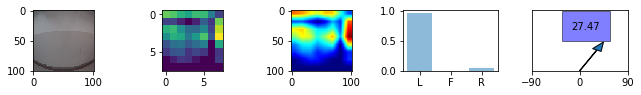

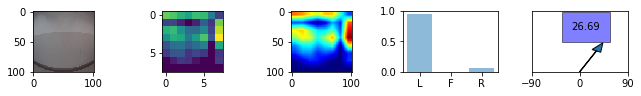

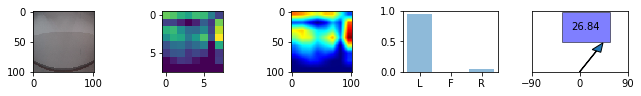

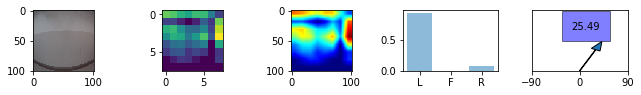

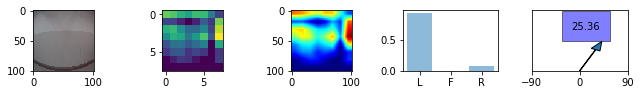

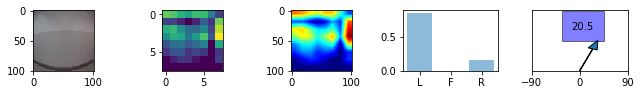

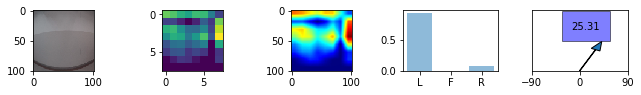

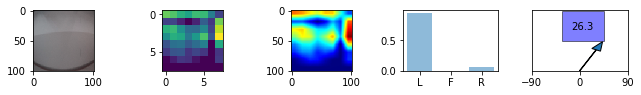

In [11]:
for i in range(len(yaw_angles)):
    yaw_angle = yaw_angles[i]
    prediction = predictions[i]
    inference_image = images_np[i]
    
    labels = ('L','F','R')
    y_pos = np.arange(len(labels))

    plt.figure(figsize=(10, 1))
    plt.subplot(151)
    plt.imshow(inference_image)
    
    #plt.figure(figsize=(9, 2))
    plt.subplot(152)
    plt.imshow(activation_maps[i])
    
    #plt.figure(figsize=(9, 2))
    plt.subplot(153)
    plt.imshow(heat_maps[i])

    plt.subplot(154)
    plt.bar(y_pos, [prediction[0][1], prediction[0][0], prediction[0][2]], align='center', alpha=0.5)
    plt.xticks(y_pos, labels)

    ax = plt.subplot(155)
    ax.set_xlim([-90,90])
    ax.set_ylim([0,181])
    ax.get_yaxis().set_visible(False)
    ax.set_xticks([-90,0,90])
    ax.text(-15, 125, str(round(yaw_angle,2)),
            bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})
    plt.arrow(0, 0, 70 * math.sin(math.radians(yaw_angle)), 70 * math.cos(math.radians(yaw_angle)), shape="full",head_width=181*0.1, width=181*0.005)

    plt.subplots_adjust(top=0.92, 
                        bottom=0.08, 
                        left=0.10, 
                        right=0.95, 
                        hspace=0.25,
                        wspace=0.35)

    plt.show()